### Program for analyse og visualisering av havnivåstigning

Denne koden analyserer og visualiserer endringer i havnivå fra 1992 til 2025. Den henter sanntidsdata fra NASA. Brukeren kan enkelt regulerer øvre og nedre grense slik at usannsynelige verdier blir filtrert bort. Deretter fyller koden inn manglende data ved bruk av interpolasjon. Brukeren kan velge mellom ulike visualiseringer via en interaktiv meny laget med widgets. Visualiseringene inkluderer linjediagram, punktdiagram, regresjonsanalyse, glidende gjennomsnitt, boksplott og en interaktiv graf laget med Plotly. Koden viser også hvor sterk sammenheng det er mellom år og havnivå ved hjelp av Pearson-korrelasjon. Alle grafer er tydelig merket med akser og titler for å gjøre informasjonen lett å forstå.

Dropdown(description='Velg analyse:', index=3, layout=Layout(width='70%'), options=(('📊 Pearson-korrelasjon me…

Button(description='Vis graf', style=ButtonStyle())

Output()

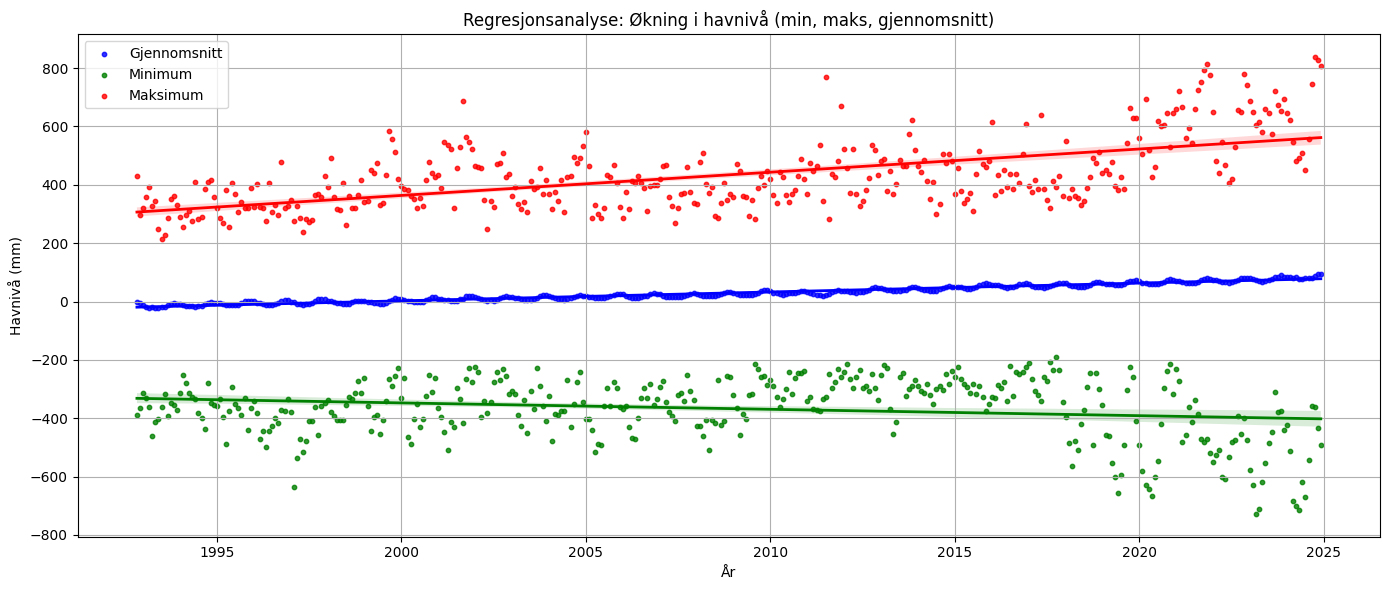

In [ ]:
import numpy as np 
import pandas as pd
import requests
from datetime import datetime
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
import ipywidgets as widgets
from IPython.display import display, clear_output

# For å bruke Plotly 
pio.renderers.default = "vscode"

# Henting av data
response = requests.get(
    "https://sealevel-nexus.jpl.nasa.gov/timeSeriesSpark",
    params={
        "ds": "NASA_SSH_REF_SIMPLE_GRID_V1_Monthly",
        "b": "-180.0,-90.0,180.0,90.0",
        "startTime": "1992-01-01T00:00:00Z",
        "endTime": "2025-01-01T00:00:00Z",
        "output": "JSON"
    }
)

# Konverter JSON til DataFrame
if response.ok and "data" in response.json():
    raw_data = [item for sublist in response.json()["data"] for item in sublist]
    df = pd.DataFrame(raw_data)
else:
    raise ValueError("Feil ved henting av data.")

# Lag en ny DataFrame med tidsstempel
df["iso_time"] = pd.to_datetime(df["iso_time"])
df["år"] = df["iso_time"].dt.year
df["måned"] = df["iso_time"].dt.to_period("M")
df["mean_mm"] = df["mean"] * 1000
df["min_mm"] = df["min"] * 1000
df["max_mm"] = df["max"] * 1000

# Rensing og utfylling av manglende punkter

# 1. Setter øvre og nedre grenser for gyldige verdier i hver måling
grenser = {
    "mean": (-1, 1),
    "min": (-1, 1),
    "max": (-1, 1)
}

# 2. Lager en maske for ugyldige verdier
ugyldig = pd.Series(False, index=df.index)
for kolonne, (min_grense, max_grense) in grenser.items():
    ugyldig |= ~df[kolonne].between(min_grense, max_grense)

antall_rensede = ugyldig.sum()

# 3. Setter ugyldige verdier til NaN
df.loc[ugyldig, ["mean_mm", "min_mm", "max_mm"]] = np.nan

# 4. Bruk interpolasjon for å fylle inn manglende verdier
df[["mean_mm", "min_mm", "max_mm"]] = df[["mean_mm", "min_mm", "max_mm"]].interpolate(method="linear")

# df er nå en komplett dataserie uten hull, og vi bruker denne videre
df_renset = df.copy()

# Lager et utgangsfelt som kan vise tekstlig output
output_tekst = widgets.Output()

# Visningsfunksjoner
def vis_korrelasjon():
    clear_output(wait=True)
    display(valg_boks, knapp, output_tekst)
    korrelasjon, _ = pearsonr(df_renset["år"], df_renset["mean_mm"])
    with output_tekst:
        output_tekst.clear_output()
        print(f"\nSammenheng mellom år og havnivåstigning (1992–2025): {korrelasjon:.3f}")
        if korrelasjon > 0.7:
            print("📈 Sterk positiv sammenheng – havnivået øker over tid.")
        elif korrelasjon < -0.7:
            print("📉 Sterk negativ sammenheng – havnivået synker over tid.")
        else:
            print("➖ Svak eller ingen klar sammenheng.")

def vis_linjediagram():
    plt.figure(figsize=(12, 5))
    sns.lineplot(data=df_renset, x="iso_time", y="mean_mm", color="blue")
    plt.title("Gjennomsnittlig økning i havnivå fra 1992 til 2025 (mm)")
    plt.xlabel("Tid")
    plt.ylabel("Havnivå (mm)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def vis_punktdiagram():
    df_mnd = df_renset[["måned", "mean_mm"]].dropna()
    df_mnd["dato"] = df_mnd["måned"].dt.to_timestamp()
    plt.figure(figsize=(12, 5))
    plt.scatter(df_mnd["dato"], df_mnd["mean_mm"], color="green", alpha=0.7, s=10)
    plt.xlabel("År")
    plt.ylabel("Havnivå (mm)")
    plt.title("Månedlig havnivåøkning fra 1992 til 2025 (punktvis)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def vis_regresjon():
    df_mnd = df_renset[["måned", "mean_mm", "min_mm", "max_mm"]].dropna()
    df_mnd["tid"] = df_mnd["måned"].dt.to_timestamp()
    df_mnd["år"] = df_mnd["tid"].dt.year + df_mnd["tid"].dt.month / 12

    plt.figure(figsize=(14, 6))
    sns.regplot(x="år", y="mean_mm", data=df_mnd, scatter=True, label="Gjennomsnitt", color="blue", scatter_kws={'s':10}, line_kws={'linewidth':2})
    sns.regplot(x="år", y="min_mm", data=df_mnd, scatter=True, label="Minimum", color="green", scatter_kws={'s':10}, line_kws={'linewidth':2})
    sns.regplot(x="år", y="max_mm", data=df_mnd, scatter=True, label="Maksimum", color="red", scatter_kws={'s':10}, line_kws={'linewidth':2})
    plt.title("Regresjonsanalyse: Økning i havnivå (min, maks, gjennomsnitt)")
    plt.xlabel("År")
    plt.ylabel("Havnivå (mm)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def vis_glidende_gjennomsnitt():
    df_renset["glidende_mean"] = df_renset["mean_mm"].rolling(window=12, min_periods=1).mean()
    plt.figure(figsize=(12, 5))
    plt.plot(df_renset["iso_time"], df_renset["mean_mm"], label="Rådata", alpha=0.3)
    plt.plot(df_renset["iso_time"], df_renset["glidende_mean"], label="12 måneders glidende gjennomsnitt", color="red")
    plt.xlabel("Tid")
    plt.ylabel("Havnivå (mm)")
    plt.title("Utvikling i havnivå fra 1992 til 2025: Glidende gjennomsnitt")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def vis_boksplott():
    plt.figure(figsize=(15, 6))
    df_renset.boxplot(column="mean_mm", by="år", grid=True, showfliers=False)
    plt.title("Årlig fordeling av havnivåøkning (1992–2025)")
    plt.suptitle("")
    plt.xlabel("År")
    plt.xticks(rotation=45)
    plt.ylabel("Havnivå (mm)")
    plt.tight_layout()
    plt.show()

def vis_interaktiv():
    df_årlig = df_renset.groupby("år")["mean_mm"].mean().reset_index()
    fig = px.line(
        df_årlig,
        x="år",
        y="mean_mm",
        title="Interaktiv visning: Gjennomsnittlig økning i havnivå (1992–2025)",
        labels={"mean_mm": "Havnivå (mm)", "år": "År"}
    )
    fig.update_layout(hovermode="x unified")
    fig.show()

# Interaktiv meny for valg av analyse
def interaktiv_meny():
    global valg_boks, knapp
    valg_boks = widgets.Dropdown(
        options=[
            ("📊 Pearson-korrelasjon mellom år og gjennomsnittlig havnivåstigning", 1),
            ("📈 Linjediagram: Gjennomsnittlig økning i havnivå over tid (Seaborn)", 2),
            ("🔹 Punktdiagram: Gjennomsnittlig utvikling i havnivå per måned", 3),
            ("📉 Regresjonsanalyse: Min, maks og gjennomsnitt", 4),
            ("📏 Glidende gjennomsnitt (12 måneder)", 5),
            ("📦 Boksplott: Fordeling per år", 6),
            ("🌍 Interaktiv graf med årlig gjennomsnitt av havnivåstigning fra 1992-2025 (Plotly)", 7),
        ],
        description="Velg analyse:",
        style={"description_width": "initial"},
        layout=widgets.Layout(width="70%")
    )

    knapp = widgets.Button(description="Vis graf")

    def vis_valg(b):
        clear_output(wait=True)
        display(valg_boks, knapp, output_tekst)
        valg = valg_boks.value
        output_tekst.clear_output()
        if valg == 1:
            vis_korrelasjon()
        elif valg == 2:
            vis_linjediagram()
        elif valg == 3:
            vis_punktdiagram()
        elif valg == 4:
            vis_regresjon()
        elif valg == 5:
            vis_glidende_gjennomsnitt()
        elif valg == 6:
            vis_boksplott()
        elif valg == 7:
            vis_interaktiv()

    knapp.on_click(vis_valg)
    display(valg_boks, knapp, output_tekst)

# Antall rensende eller manglende datapunkter som ble interpolert
print(f"🔍 Antall rensede eller manglende datapunkter som ble interpolert: {antall_rensede}")

# Start menyen
interaktiv_meny()